In [2]:
%load_ext autoreload
%autoreload
%matplotlib widget
import importlib
from SOAEpeaks import load_df
import phaseco as pc
from phaseco import *
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.signal.windows import gaussian
importlib.reload(pc)
import ipywidgets as widgets
from IPython.display import display



In [ ]:
# Get different species
df = load_df(laptop=True, dfs_to_load=["Curated Data"])
wf_list = []
for species in ['Anolis', 'Owl', 'Human']:
    df_species = df[df['species'] == species]
    for i in range (3):
        row = df_species.iloc[i]
        wf_title = row['filepath'].split('\\')[-1]
        wf_list.append((row['wf'], row['sr'], wf_title, species))
# Get one wf in particular
wf_idx = 2

if wf_idx < 3:
    species = 'lizard'
elif wf_idx < 6:
    species = 'owl'
else:
    species = 'human'

wf = wf_list[wf_idx][0]
fs = wf_list[wf_idx][1]
wf_title = wf_list[wf_idx][2]
del df

In [ ]:
"Calculate asymm species comparison (rho=1)"

# Set parameters
tauS = 2**11
tau = tauS / 44100 # Everyone uses the same tau
min_xi = 0.0025
max_xi = tau
base_num_xis = 50

# Set if we use the below defined rho or the fwhm
dynamic_windowing = True
rho = 2 # For dynamic windowing
fwhm = max_xi # For fixed windowing

if dynamic_windowing:
    rho = rho
    fwhm = None
    pkl_fn = f'asymm_species_coherences_list_rho{rho}'
else:
    rho = None
    fwhm = fwhm
    pkl_fn = f'asymm_species_coherences_list_fwhm{fwhm:.5f}'

species_coherences_list = []
for j, (wf, fs, wf_title, species) in enumerate(wf_list):    
    # Make species adjustments
    match species:
        case 'Anolis':
            max_xi = tau # Tau seems to be long enough for the lizards
            num_xis = base_num_xis
        case 'Owl':
            max_xi = tau * 2 # Go out a bit farther for owls
            num_xis = base_num_xis * 2 # Double xi resolution to compensate
        case 'Human':
            max_xi = tau * 32 # Go out way farther for humans
            num_xis = base_num_xis * 8 # Up the xi resolution a bit to compensate
        
    if fs != 44100: # Prioritize tau homogenity with other species over ideal tauS = 2**N
        tauS = int(tau * fs)
        
    # Calculate xi and frequency arrays
    xis = np.linspace(min_xi, max_xi, num_xis)
    f = rfftfreq(tauS, 1/fs)
    
    # Make sure we have a consistent number of segments to take vector strength over since this will change with xi
    max_xiS = max(xis) * fs
    N_segs = int((len(wf) - tauS) / max_xiS)    
    
    # Initialize coherences array
    coherences = np.zeros((len(f), len(xis)))
    # Calculate coherences
    for i, xi in enumerate(xis):
        print(f"Calculating xi {i+1}/{len(xis)} for wf {j+1}/{len(wf_list)}")
        coherences[:, i] = get_asym_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, N_segs=N_segs, rho=rho, fwhm=fwhm)[1]
        
    # Add to list
    species_coherences_list.append((coherences, f, xis, tau, wf_title, species))


with open(pkl_fn + '.pkl', 'wb') as f:
    pickle.dump(species_coherences_list, f)
    

In [ ]:
"Plot asymm different species comparison"
cmap = 'magma'
plt.close('all')
plt.figure(figsize=(20, 10))
for i, (coherences, f, xis, tau, wf_title, species) in enumerate(species_coherences_list):
    plt.subplot(3, 3, i + 1)
    if species == "Owl":
        max_khz = 12
    # if species =='Human':
        # plt.xscale('log')
    max_khz = 6
    plot_colossogram(coherences, f, xis, tau, title=wf_title, max_khz=max_khz, cmap=cmap)

if dynamic_windowing:
    suptitle = rf'Colossogram Species Comparison: Asymmetric Window ($\tau={tau:.3f}s$, $\rho = {rho}$)'
    filename = rf'Asymmetric colossogram species comparison (tau={tau:.3f}, rho={rho})'
else:
    suptitle = rf'Colossogram Species Comparison: Asymmetric Window ($\tau={tau:.3f}s$, $FWHM={fwhm:.5f}s$)'
    filename = rf'Asymmetric colossogram species comparison (tau={tau:.3f}, FWHM={fwhm:.5f})'

plt.suptitle(suptitle, fontsize=20)
plt.tight_layout()
plt.savefig(filename + '.png', dpi=300)
plt.show()

In [ ]:
"Calculate asymmetric comparison"
tauS = 2**11
tau = tauS / 44100
min_xi = 0.0025
max_xi = tau * 2
num_xis = 50

# Either set rho (for linearly increasing fwhm) or set fwhm directly, other one should be None
rho=None
fwhm = min_xi


# # TEST
# xi = tau/10
# N_segs = None
# plt.close('all')
# get_asym_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, fwhm=fwhm, rho=rho, N_segs=N_segs, double_fft=False)
# # END TEST


# Calculate xi and frequency arrays
xis = np.linspace(min_xi, max_xi, num_xis)
f = rfftfreq(tauS, 1/fs)
    
# Make sure we have a consistent number of segments to take vector strength over since this will change with xi
max_xiS = max(xis) * fs
N_segs = int((len(wf) - tauS) / max_xiS)    
    
# Initialize coherences array
reg_coherences = np.zeros((len(f), len(xis)))
asym_coherences = np.zeros((len(f), len(xis)))
asym_double_coherences = np.zeros((len(f), len(xis)))

# Calculate coherences
for i, xi in enumerate(xis):
    reg_coherences[:, i] = get_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, ref_type="next_seg", N_segs=N_segs, rho=rho)[1]
    asym_coherences[:, i] = get_asym_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, fwhm=fwhm, rho=rho, N_segs=N_segs, double_fft=False)[1]
    asym_double_coherences[:, i] = get_asym_coherence(wf=wf, fs=fs, tauS=tauS, fwhm=fwhm, xi=xi, rho=rho, N_segs=N_segs, double_fft=True)[1]
    


In [ ]:
"Plot asymmetric comparison"
plt.close('all')
plt.figure(figsize=(12, 12))
for i, (coherences, title) in enumerate(zip([reg_coherences, asym_coherences, asym_double_coherences], ["Regular Gaussian", "Asymmetric Gaussian", "Double Asymmetric Gaussian"])):
    plt.subplot(3, 1, i + 1)
    max_khz = 10
    plot_colossogram(coherences, f, xis, tau, title=title, max_khz=max_khz, cmap='magma')
# plt.suptitle(rf"{wf_title} [$\tau$ = {tau:.4f}] [$\rho$ = {rho:.2f}]", fontsize=16)
plt.suptitle(rf"{wf_title} [$\tau$ = {tau:.4f}] [FWHM = min_xi]", fontsize=16)
plt.tight_layout()
# plt.savefig(f'asym_colossogram_comparison_{species}{wf_idx}_rho{rho}.png', dpi=300)
plt.savefig(f'asym_colossogram_comparison_{species}{wf_idx}_fwhm_min_xi.png', dpi=300)
plt.show()

In [ ]:
# Subtracting Background Noise?
tauS = 2**11
tau = tauS / fs
xi = tau / 10

f, coherence = get_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, ref_type="next_seg")
f, coherence_sigma = get_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, ref_type="next_seg", rho=1)

plt.close('all')
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(f, coherence, label='No Window')
plt.plot(f, coherence_sigma, label='Gaussian')
plt.ylim(-0.5, 1)
plt.xlim(0, 10000)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(f, coherence - 0.8, label='No Window (floor subtracted)')
plt.plot(f, coherence_sigma - 0.2, label='Gaussian (floor subtracted)')
plt.ylim(-0.5, 1)
plt.xlim(0, 10000)
plt.legend()
plt.show()

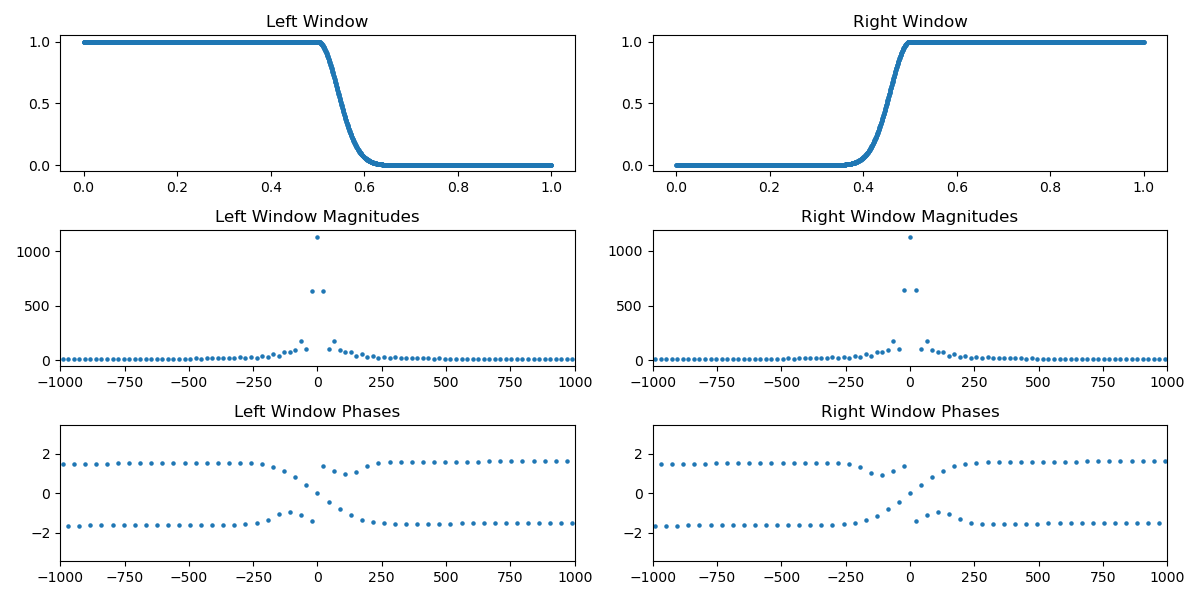

In [14]:
"Properties of Window Function"
tauS = 2**11
fs = 44100
tau = tauS / fs
sigmaS = get_sigmaS(fwhm=tau/10, fs=fs)
gaussian = get_window(('gauss', sigmaS), tauS)
left_window = np.ones(int(tauS))
right_window = np.ones(int(tauS))
left_window[int(tauS/2):] = gaussian[int(tauS/2):] # Left window starts with ones and ends with gaussian (gaussian on overlapping side)
right_window[0:int(tauS/2)] = gaussian[0:int(tauS/2)] # Vice versa
t = np.linspace(0, 1, tauS)
fftshift_wins = True

# Get DFT of windows
if fftshift_wins:
    left_window_dft = np.fft.fft(np.fft.fftshift(left_window))
    right_window_dft = np.fft.fft(np.fft.fftshift(right_window))
else:
    left_window_dft = np.fft.fft(left_window)
    right_window_dft = np.fft.fft(right_window)
f = np.fft.fftfreq(len(t), d=1/fs)

# Plot windows
f_width = 1000

plt.close('all')
plt.figure(figsize=(12, 6))
plt.subplot(3, 2, 1)
plt.scatter(t, left_window, s=5)
plt.title('Left Window')
plt.subplot(3, 2, 2)
plt.scatter(t, right_window, s=5)
plt.title('Right Window')
plt.subplot(3, 2, 3)
plt.xlim(-f_width, f_width)
plt.scatter(f, np.abs(left_window_dft), s=5)
plt.title('Left Window Magnitudes')
plt.subplot(3, 2, 4)
plt.xlim(-f_width, f_width)
plt.scatter(f, np.abs(right_window_dft), s=5)
plt.title('Right Window Magnitudes')
plt.subplot(3, 2, 5)
plt.xlim(-f_width, f_width)
plt.scatter(f, np.angle(left_window_dft), s=5)
plt.title('Left Window Phases')
plt.subplot(3, 2, 6)
plt.xlim(-f_width, f_width)
plt.scatter(f, np.angle(right_window_dft), s=5)
plt.title('Right Window Phases')
plt.tight_layout()
plt.show()
